<a href="https://colab.research.google.com/github/eduardomtzchenoweth/curso_prepedeutico_CD/blob/main/Coneccion_BD_Libreta_MtzChenoweth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANALISIS DE DATOS UTILIZANDO PANDAS**
### Para este analisis se utilizaron los [datos abiertos](http://www.dgis.salud.gob.mx/contenidos/basesdedatos/Datos_Abiertos_gobmx.html) de la **Secretaria de Salud de Mexico**. Se utilizaron los [registros de urgencias de 2022](http://www.dgis.salud.gob.mx/contenidos/basesdedatos/da_urgencias_gobmx.html).
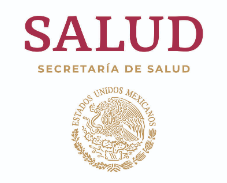
---
Para este conjunto de datos se desea encontrar la relacion entre la hora de ingreso de la urgencia y el motivo de urgencia que es en el estado de Ciudad de Mexico, los motivos de urgencias que existen en este conjunto de datos son:
1. ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA: Se refiere cuando la o las afecciones tratadas fueron resultado de un accidente, envenenamiento y
violencia.                                     
2. MÉDICA:Se refiere cuando la o las afecciones tratadas fueron resultado de una enfermedad.

3. GINECO-OBSTÉTRICA: Se refiere cuando la o las afecciones tratadas fueron resultado del embarazo, parto o puerperio.

4. PEDIÁTRICA: Se refiere cuando la o las afecciones tratadas fueron dirigidas a un paciente pediátrico menor de 18 años.

5. NO ESPECIFICADO

De los cuales se omitira el no especificado, por motivo de querer estudiar la relacion del motivo especifico de urgencia con la hora, este dato no arrojaria informacion significativa.

*   **Hipotesis principal**: El motivo de urgencia esta relacionado con la hora de ingreso de la urgencia.

*   **Hipotesis secundaria**: El caso de ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA sera mas comun entre las 20:00 y las 6:00.

---
* Pagina donde se extrajeron los datos y catalogo de los datos: http://www.dgis.salud.gob.mx/contenidos/basesdedatos/da_urgencias_gobmx.html

* INSTRUCTIVO DE LLENADO DE LA HOJA DIARIA DEL SERVICIO DE URGENCIAS (SINBA-SEUL-16-P DGIS) MODELO 2024: http://www.dgis.salud.gob.mx/descargas/urgencias/pdf/Instructivo_Urgencias_2024.pdf
---


## *Eduardo Alonso Martinez Chenoweth*

Instalamos las librerias necesarias para poder llevar acabo esta practica:
* mysql-connector-python: Para realizar la conexion a la base de datos.  
* matplotlib: Para graficar los datos que se desean analizar.
* pandas: Para manejar los datos de manera mas sencilla.

In [ ]:
!pip install mysql-connector-python matplotlib pandas


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Importamos las librerias instaladas.

In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

### Conectar a la base de datos

In [ ]:
def connect_to_db():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="1234",
        database="URGENCIAS_CDMX"
    )

### Realizar una consulta y devolver los datos en un DataFrame de pandas

In [ ]:
def fetch_data(query):
    connection = connect_to_db()
    cursor = connection.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    cursor.close()
    connection.close()
    return df

### Graficar los datos

In [ ]:
def plot_data(df):
    df.plot(kind='bar', x='name', y='population')
    plt.xlabel('Municipios')
    plt.ylabel('Habitantes')
    plt.title('Población total de los municipios de Sonora')
    plt.show()

### Obtener datos filtrados por fecha de ingeso del año 2022 y de la Ciudad de Mexico y unicamente las columnas de `fechaingreso, hora_ingreso, MOTATE, ENTRESIDENCIA`.

In [ ]:
query = "SELECT fechaingreso, hora_ingreso, MOTATE, ENTRESIDENCIA FROM urgencias WHERE fechaingreso >= '2022-01-01' AND ENTRESIDENCIA = 9 ORDER BY fechaingreso;"
df = fetch_data(query)
df['ENTRESIDENCIA'].unique()

array(['09'], dtype=object)

Observamos las informacion de los datos filtrados.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546196 entries, 0 to 546195
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   fechaingreso   546196 non-null  object
 1   hora_ingreso   546196 non-null  object
 2   MOTATE         546196 non-null  object
 3   ENTRESIDENCIA  546196 non-null  object
dtypes: object(4)
memory usage: 16.7+ MB


Primero, seteamos la variable `fechaingreso` como index para manegar los datos de una manera mas comoda a la hora de filtrarlos.

In [ ]:
df['fechaingreso'] = pd.to_datetime(df['fechaingreso'])
df.set_index('fechaingreso', inplace = True)
df.head()

,hora_ingreso,MOTATE,ENTRESIDENCIA
fechaingreso,,,
2022-01-01,23:42,2,09
2022-01-01,08:00,2,09
2022-01-01,08:30,2,09
2022-01-01,07:30,2,09
2022-01-01,11:30,1,09


Para una facilitar la lectura de los datos cambiamos el nombre de la variable MOTATE, de un valor numero al texto que aparece en el catalogo de datos proporcionado en la misma [pagina](http://www.dgis.salud.gob.mx/contenidos/basesdedatos/da_urgencias_gobmx.html).

In [ ]:
df['MOTATE'] = df['MOTATE'].replace({"1":'ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA',
                                                "2": 'MÉDICA',
                                                "3": 'GINECO-OBSTÉTRICA',
                                                "4": 'PEDIÁTRICA',
                                                "9": 'NO ESPECIFICADO'})
df['MOTATE'].unique()

array(['MÉDICA', 'ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA', 'PEDIÁTRICA',
       'GINECO-OBSTÉTRICA', 'NO ESPECIFICADO'], dtype=object)

Agregamos una nueva columna llamada `hora_formateada` la cual se obtiene de la columna `hora_ingreso` pero con un formateo para que unicamente tome en cuenta la hora sin los minutos, de esta manera sera mucho mas facil agrupar los datos en grupos mas grandes y observar el comportamiento de los datos por rango de horas.

In [ ]:
df['hora_ingreso'] = pd.to_datetime(df['hora_ingreso'], format='%H:%M', errors='coerce')
df['hora_formateada'] = df['hora_ingreso'].dt.floor('H')
df['hora_formateada'] = df['hora_formateada'].dt.strftime('%H:%M')
df.head()

C:\Users\Eddy\AppData\Local\Temp\ipykernel_17168\956931097.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hora_formateada'] = df['hora_ingreso'].dt.floor('H')


,hora_ingreso,MOTATE,ENTRESIDENCIA,hora_formateada
fechaingreso,,,,
2022-01-01,1900-01-01 23:42:00,MÉDICA,09,23:00
2022-01-01,1900-01-01 08:00:00,MÉDICA,09,08:00
2022-01-01,1900-01-01 08:30:00,MÉDICA,09,08:00
2022-01-01,1900-01-01 07:30:00,MÉDICA,09,07:00
2022-01-01,1900-01-01 11:30:00,"ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA",09,11:00


Agregamos una nueva colunma llamada `hora_formateada` la cual se obtiene de la columna `hora_ingreso` pero con un formateo para que unicamente tome en cuenta la hora sin los minutos, de esta manera sera mucho mas facil agrupar los datos en grupos mas grandes y observar el comportamiento de los datos por rango de horas.

In [ ]:
df_cdmx_group =df.groupby(['hora_formateada','MOTATE'])[['MOTATE']].count()
df_cdmx_group = df_cdmx_group.rename(columns={'MOTATE': 'cantidad'})
df_cdmx_group

cantidad
hora_formateada MOTATE                                          
00:00           ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA      2845
                GINECO-OBSTÉTRICA                           3611
                MÉDICA                                      7293
                NO ESPECIFICADO                                2
                PEDIÁTRICA                                  3306
...                                                          ...
22:00           PEDIÁTRICA                                  4426
23:00           ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA      3625
                GINECO-OBSTÉTRICA                           4153
                MÉDICA                                      8813
                PEDIÁTRICA                                  4080

[100 rows x 1 columns]

De la columna `hora_formateada` se obtiene cada hora unica y se guardara en un arreglo. Esto se hace por la naturaleza de la practica, con el fin de utilizar la funcion `unique`, perfectamente se podria generar un array utilizando `numphy` con las horas, de cualquier manera este metodo tambien es valido.

In [ ]:
horas_unicas = df['hora_formateada'].unique()

serie_tiempos = pd.Series(horas_unicas)
serie_tiempos = pd.to_datetime(serie_tiempos, format='%H:%M', errors='coerce')
serie_tiempos_ordenada = serie_tiempos.sort_values()
arreglo_tiempos_ordenado = serie_tiempos_ordenada.dt.strftime('%H:%M').values[:-1]
print(len(arreglo_tiempos_ordenado))

24


Guardamos en variables separadas los datos agrupados por horas pero separando el motivo de urgencia en cada una de las variable.

In [ ]:
accidentes = df_cdmx_group.loc[df_cdmx_group.index.get_level_values('MOTATE') == 'ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA']['cantidad']
gineco = df_cdmx_group.loc[df_cdmx_group.index.get_level_values('MOTATE') == 'GINECO-OBSTÉTRICA']['cantidad']
medica = df_cdmx_group.loc[df_cdmx_group.index.get_level_values('MOTATE') == 'MÉDICA']['cantidad']
pediatrica = df_cdmx_group.loc[df_cdmx_group.index.get_level_values('MOTATE') == 'PEDIÁTRICA']['cantidad']

Graficamos los datos, cada linea representa un motivo de urgencia, en el eje x es la hora a la que se presenta la urgencia, en el eje y la cantidad de urgencias.

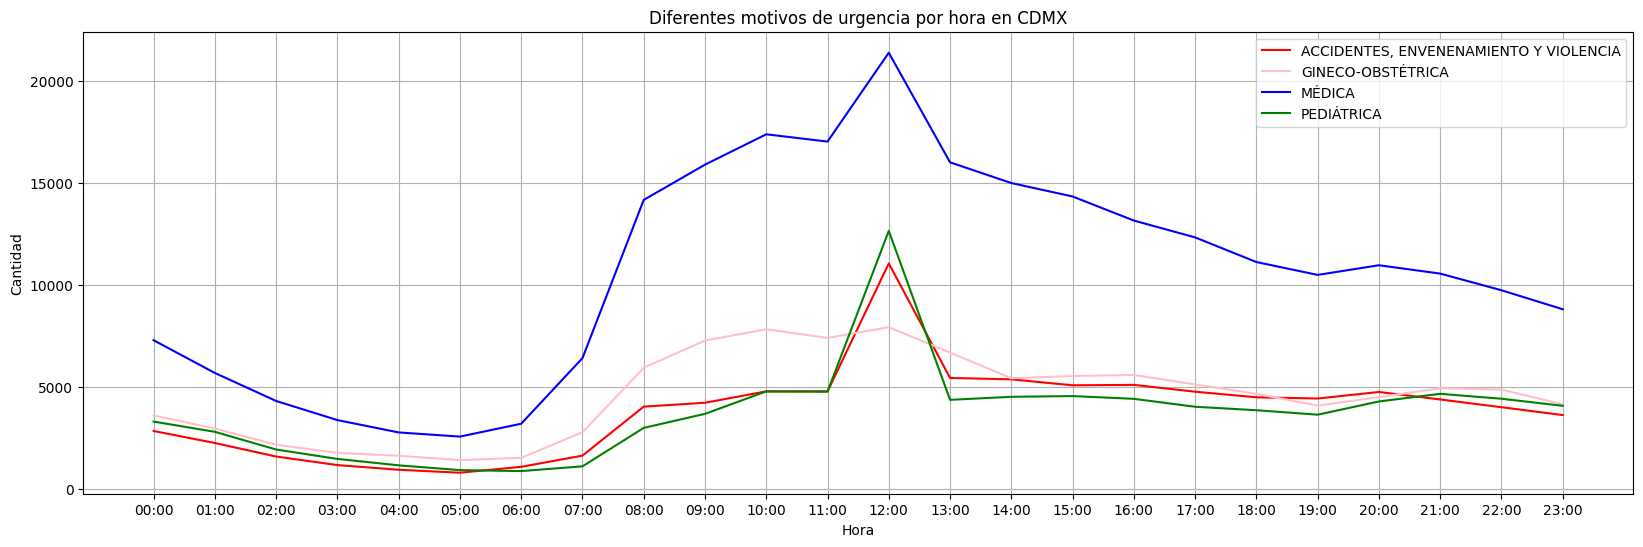

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(arreglo_tiempos_ordenado, accidentes, label="ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA", color='red')
plt.plot(arreglo_tiempos_ordenado, gineco, label="GINECO-OBSTÉTRICA", color='pink')
plt.plot(arreglo_tiempos_ordenado, medica, label="MÉDICA", color='blue')
plt.plot(arreglo_tiempos_ordenado, pediatrica, label="PEDIÁTRICA", color='green')

plt.title('Diferentes motivos de urgencia por hora en CDMX')
plt.xlabel('Hora')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)

plt.show()

## Analisis de los datos:
Podemos observar que la hipotesis principal de "El motivo de urgencia esta relacionado con la hora de ingreso de la urgencia." es parcialmente cierta. En efecto, esta hipotesis se ve respaldad por el pico que tiene las urgencias **medicas** a apartir de las 6:00, se observa un gran cambio apartir de esa hora en la grafica. Tambien observamos un cambio, aunque un menor, en el caso de las urgencias de motivo **gineco-obstetrica**, teniendo un crecimiento alrededor de la misma hora que las urgencias **medicas**.

Por otra parte la hipotesis secundaria de "El caso de ACCIDENTES, ENVENENAMIENTO Y VIOLENCIA sera mas comun entre las 20:00 y las 6:00." puede ser rechazada ya que no se no observa un cambio significativo entre las horas supuestas en la propuestas.

---

De este analisis podemos concluir que, en efecto existe una relacion entre la hora de ingreso y el motivo de urgencia, cumpliendose para el caso de que el la urgencia sea del motivo **medica** o **gineco-obstetrica**. Esta informacion podria ser util para poder preparar a los centros de atencion medica con el equipo necesario para atender este motivo de urgencias con mayor eficiencia.

Para conocer los motivos por los cuales estos son los motivos con una mayor relacion con la hora se necesitaria realizar un analizis mas profundo y comparar otro motivo de variables que por cuestiones de tiempo se dejaran para otro momento, pero se planetara la hipotesis sobre esa icognita: "Los pacientes de CDMX con urgencias de motivo **medica** o **gineco-obstetrica** son mas frecuentes a las 6:00 por motivos de que despiertan por las mañanas con malestares"